### Boom Bikes - Regression Analysis

In [6]:
# Required Libraries

import pandas as pd
import numpy as np

# Model Selection
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

## Problem Statement

### Business Problem

**Context:** 
A bike-sharing system is a service where bikes are made available for short-term use to individuals for a price or free. These bikes are borrowed from a dock, which is usually computer-controlled, and can be returned to any other dock in the system.

**Current Situation:**
BoomBikes, a US bike-sharing provider, has experienced a significant drop in revenues due to the ongoing COVID-19 pandemic. The company is struggling to sustain itself in the current market scenario.

**Objective:**
To develop a strategic business plan to accelerate revenue recovery post-lockdown and capitalize on the renewed demand for bike-sharing services.

### Data Collection
The company has gathered extensive data on daily bike demands based on various factors, including meteorological conditions and people's lifestyle changes.

### Goal

**Predictive Analysis:**
To create a regression model that accurately predicts the demand for shared bikes using the collected data.

**Business Insights:**
To gain insights into significant demand predictors and their impact, enabling informed decision-making and strategic planning for post-pandemic recovery and growth.

**Observation:**
    
    The dataset is having a Numerical Target Label. Hence it is Supervised Machine Learning Problem which can be solved using Regression Analysis

### Data Gathering

In [7]:
# Reading Dataset
boombikes_df = pd.read_csv("BoomBikes.csv")
boombikes_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [8]:
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [9]:
# List of Features in the Dataset
features = boombikes_df.columns.to_list()
features

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

In [10]:
boombikes_df.shape

(730, 16)

In [11]:
# Null Values
boombikes_df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [12]:
# checking data validation: whether any emptyness in the dataset
boombikes_df.empty

False

In [13]:
# Duplicate records
boombikes_df.duplicated().sum()

0

#### Data Dictionary

constructing the Data Dictionary of Features and their No.of Unique values


In [14]:
data_dict = boombikes_df.nunique().to_dict()
data_dict

{'instant': 730,
 'dteday': 730,
 'season': 4,
 'yr': 2,
 'mnth': 12,
 'holiday': 2,
 'weekday': 7,
 'workingday': 2,
 'weathersit': 3,
 'temp': 498,
 'atemp': 689,
 'hum': 594,
 'windspeed': 649,
 'casual': 605,
 'registered': 678,
 'cnt': 695}

### Understanding the Dataset and Features

Dataset contains ***730 records*** and ***16 features***

Dataset has ***No Null values***

Dataset has ***No Duplicate records***

Dataset has ***No Missing values***

**Independent Variables(X):**

    instant   : index record - is just serial number - it can be dropped
    dteday    : date - which explained by "yr","mnth","holiday","weekday"-so it can be dropped
    season    : seasons(1:spring,2:summer,3:fall,4:winter)-can be converted into categorical data
    yr        : year (0: 2018, 1:2019)-can be converted to into categorical data
    mnth      : month (1 to 12) - can be replce with month names
    holiday   : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)-(yes,no)
    weekday   : day of the week (0 to 6, : sun to sat)-can be replace with categorical data
    workingday: if day is neither weekend nor holiday is 1, otherwise is 0. (yes, no)
    weathersit:
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm+Scattered clouds, Light Rain+Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp      : temperature in Celsius
    atemp     : feeling temperature in Celsius
    hum       : humidity
    windspeed : wind speed
    casual    : count of casual users
    registered: count of registered users

**Dependent Variable(Y) - Target Variable**

    cnt       : count of total rental bikes including both casual and registered

    Based on the Data Dictionary, It is observed that, 
    some of the features - "season", "yr", "mnth","holiday","weekday","workingday","weathersit"
    are actually should contain categorical data instead of numerical values. 
    These features shall to be converted into the categorical features for statistical analysis.

    Similarly,
    From the features - "casual", "registered", "cnt", 
    it is observed that, the feature "cnt" which gives the count of total rental bikes including both "casual" and "registered". Hence, the features - "casual" and "registered" can be dropped.

In [15]:
boombikes_df.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [16]:
# Mapping the Catogorical Features

# Season: {1:"spring", 2: "summer", 3: "fall", 4: "winter"}
boombikes_df.season.replace({1:"spring", 2: "summer", 3: "fall", 4: "winter"}, inplace=True)

# Year: {0: "2018", 1: "2019"}
boombikes_df.yr.replace({0: "2018", 1: "2019"}, inplace= True)

# Month: {1:"jan",2:"feb",3:"mar",4:"apr",5:"may",6:"june",7:"july",8:"aug",9:"sept",10:"oct",11:"nove",12:"dec"}
boombikes_df.mnth.replace({1:"jan",2:"feb",3:"mar",4:"apr",5:"may",6:"june",
                        7:"july",8:"aug",9:"sept",10:"oct",11:"nove",12:"dec"},
                      inplace= True)
# Holiday: {0:'no', 1:"yes"}
boombikes_df.holiday.replace({0:'no', 1:"yes"}, inplace=True)

# Weekday: {0: "sunday", 1:"monday", 2:"tuesday", 3:"wednesday", 4:"thursday", 5:"friday", 6:"saturday"}
boombikes_df.weekday.replace({0: "sunday", 1:"monday", 2:"tuesday", 3:"wednesday", 4:"thursday", 5:"friday", 6:"saturday"},
                         inplace=True)

# Workingday: {1:"yes", 0:"no"}
boombikes_df.workingday.replace({1: "yes", 0: "no"}, inplace= True)

# Weathersit: {1:"clear to partly cloudy",2:"mist and cloudy",3:"light rain + light snow", 4: "heavy rain + thurnderstrom"}
boombikes_df.weathersit.replace({1:"clear to partly cloudy", 2:"mist and cloudy", 
                                 3:"light rain + light snow", 4: "heavy rain + thurnderstrom"}, inplace=True)

In [17]:
# Dropping Features - "instant", "dteday"
boombikes_df.drop(["instant", "dteday"], axis=1, inplace=True)

In [18]:
# proper dataset for analysis
boombikes_df.sample(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
401,spring,2019,feb,no,monday,yes,clear to partly cloudy,11.586969,14.82130,62.2174,10.304600,206,3578,3784
592,fall,2019,aug,no,thursday,yes,clear to partly cloudy,29.485847,32.73440,51.9167,9.500332,1338,6267,7605
404,spring,2019,feb,no,thursday,yes,clear to partly cloudy,10.865000,13.09940,56.2083,13.000479,163,3667,3830
55,spring,2018,feb,no,friday,yes,mist and cloudy,14.938268,17.52305,71.2174,23.218113,120,1341,1461
611,fall,2019,sept,no,tuesday,yes,clear to partly cloudy,29.759153,34.34440,75.5000,15.833507,867,5997,6864
298,winter,2018,oct,no,wednesday,yes,mist and cloudy,19.850847,23.64230,72.0417,9.959014,404,3490,3894
715,winter,2019,dec,no,monday,yes,mist and cloudy,16.126653,20.07500,90.7083,6.583306,212,4373,4585
569,fall,2019,july,no,tuesday,yes,clear to partly cloudy,30.784153,35.32250,65.5000,14.167418,1140,6452,7592
504,summer,2019,may,no,sunday,no,clear to partly cloudy,25.454153,29.19835,53.0417,17.042589,2704,4425,7129
374,spring,2019,jan,no,tuesday,yes,clear to partly cloudy,12.656536,15.94130,64.6522,12.565984,173,3425,3598


In [19]:
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    object 
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    object 
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    object 
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 80.0+ KB


In [20]:
# Statistical Information of numerical features
boombikes_df.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [21]:
# Statistical Information of categorical features
boombikes_df.describe(include="object")

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,fall,2018,jan,no,saturday,yes,clear to partly cloudy
freq,188,365,62,709,105,499,463


## Exploratory Data Analysis

### Univariate

#### Target Variable

Skewness: -0.04958060487648213


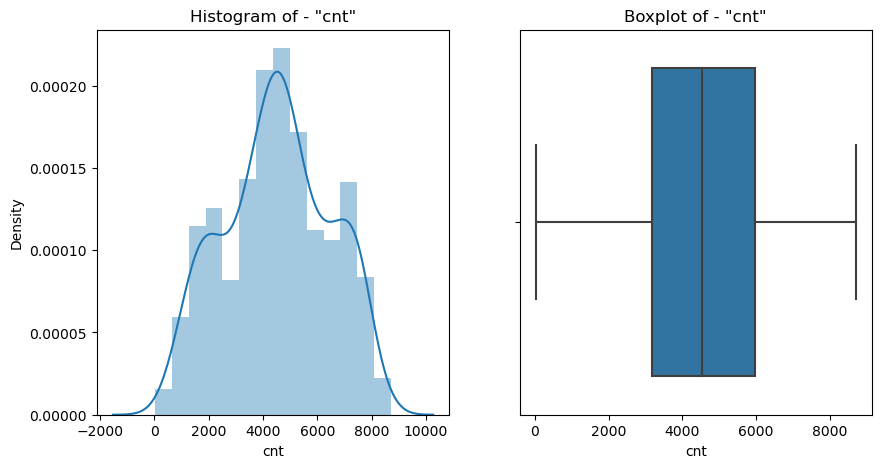

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Histogram of - "cnt"')
sns.distplot(boombikes_df.cnt)
plt.subplot(1,2,2)
plt.title('Boxplot of - "cnt"')
sns.boxplot(boombikes_df.cnt)
print("Skewness:", boombikes_df.cnt.skew())

Observation:

    The distribution of the data is Normal Distribution and there is no skewness in the data.
    Means, the data is distributed symmetrically around the mean.

In [23]:
boombikes_df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

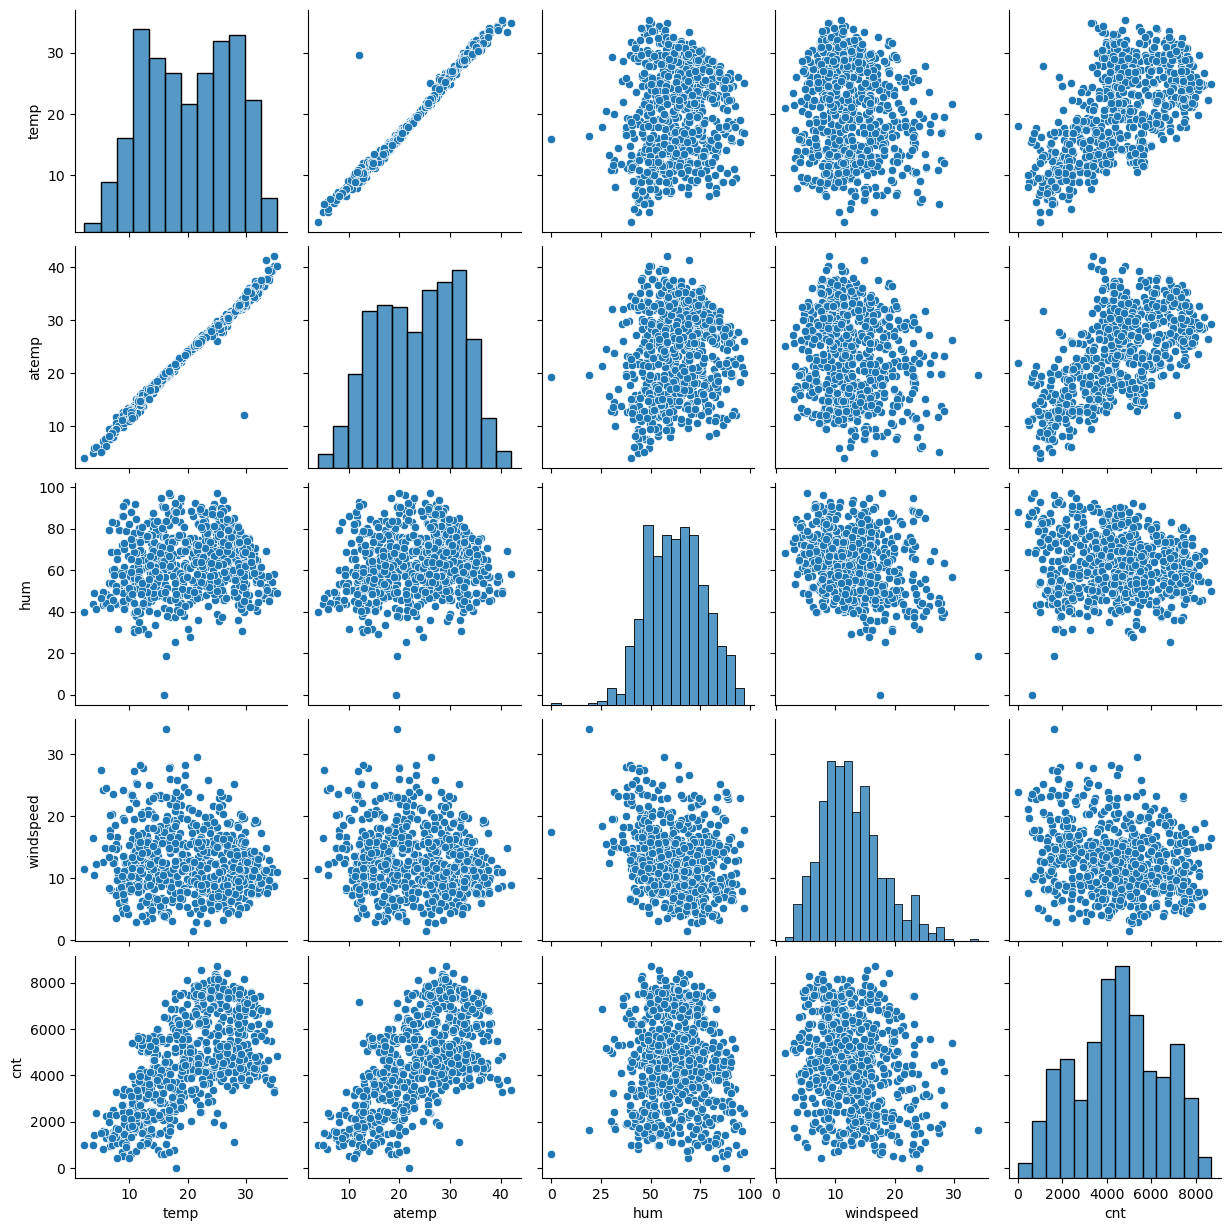

In [24]:
# Numerical features
sns.pairplot(data=boombikes_df, vars=["temp","atemp", "hum","windspeed","cnt"])

Observations:
    
    1. "temp" and "atemp" are highly correlated.
    2. "cnt" is in linear relationship with independent variables.

In [25]:
boombikes_df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

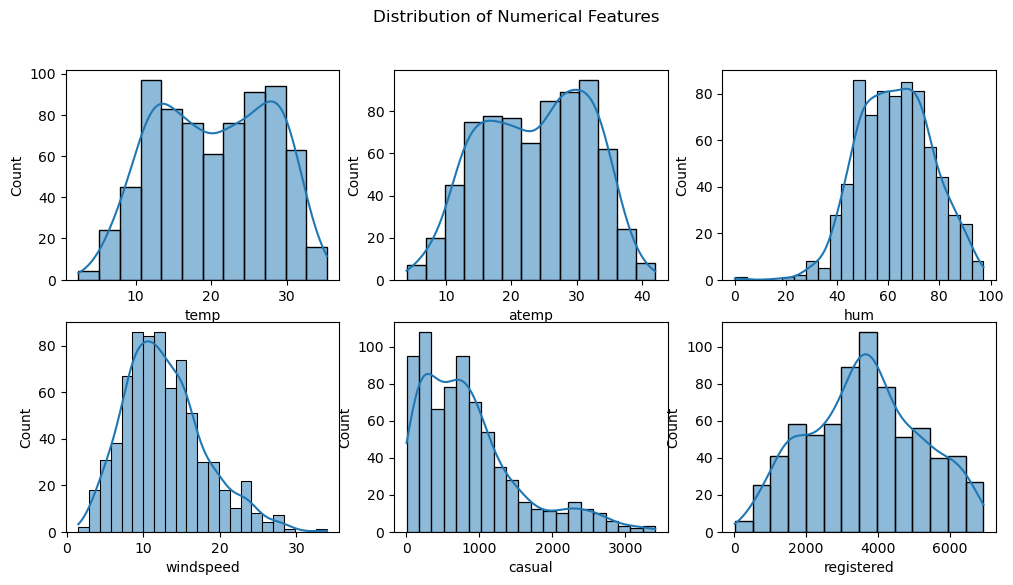

In [26]:
plt.figure(figsize=(12,6))
plt.suptitle('Distribution of Numerical Features')
plt.subplot(2,3,1)
sns.histplot(boombikes_df.temp,kde=True)
plt.subplot(2,3,2)
sns.histplot(boombikes_df.atemp, kde=True)
plt.subplot(2,3,3)
sns.histplot(boombikes_df.hum,kde=True)
plt.subplot(2,3,4)
sns.histplot(boombikes_df.windspeed,kde=True)
plt.subplot(2,3,5)
sns.histplot(boombikes_df.casual,kde=True)
plt.subplot(2,3,6)
sns.histplot(boombikes_df.registered,kde=True)
plt.show()

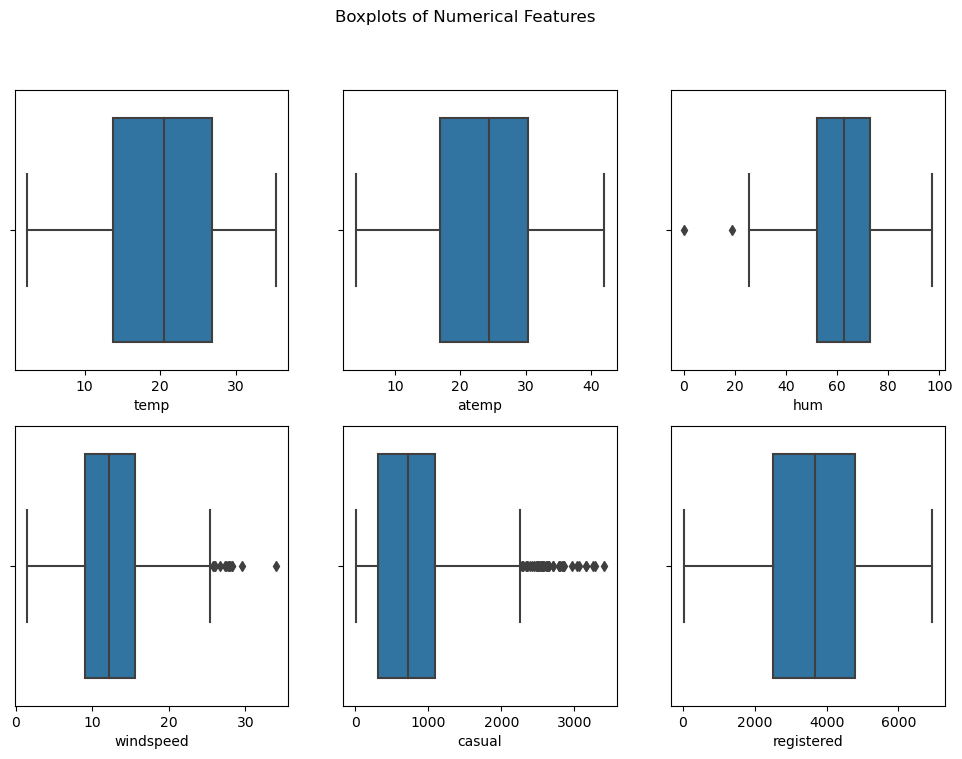

In [27]:
plt.figure(figsize=(12,8))
plt.suptitle('Boxplots of Numerical Features')
plt.subplot(2,3,1)
sns.boxplot(boombikes_df.temp)
plt.subplot(2,3,2)
sns.boxplot(boombikes_df.atemp)
plt.subplot(2,3,3)
sns.boxplot(boombikes_df.hum)
plt.subplot(2,3,4)
sns.boxplot(boombikes_df.windspeed)
plt.subplot(2,3,5)
sns.boxplot(boombikes_df.casual)
plt.subplot(2,3,6)
sns.boxplot(boombikes_df.registered)
plt.show()

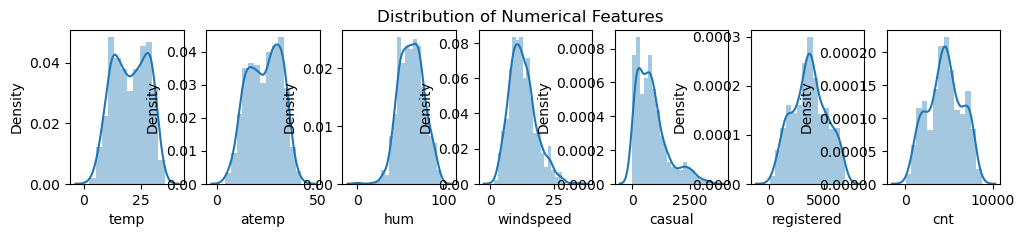

In [28]:
num_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered', 'cnt']

plt.figure(figsize=(12,2))
plt.suptitle('Distribution of Numerical Features')
for index, feature in enumerate(num_features):
    plt.subplot(1,7,index+1)
    sns.distplot(boombikes_df[feature], kde=True, )
plt.show()

In [29]:
for i in num_features:
    print(f"skewness of - '{i}:'", boombikes_df[i].skew())

skewness of - 'temp:' -0.05718748619696199
skewness of - 'atemp:' -0.13370861358035466
skewness of - 'hum:' -0.06747586253218554
skewness of - 'windspeed:' 0.6763140387852972
skewness of - 'casual:' 1.2663277435764353
skewness of - 'registered:' 0.0412110579102227
skewness of - 'cnt:' -0.04958060487648213


Observation:
    
    Skewness of "temp", "atemp", "registered" is lies between -0.05 to +0.05, says that, the data is almost normally distributed as similar to "cnt".
    
    Skewness of "windspeed" is > 0.05, says that, the data is right skewed.
    
    Skewwness of "hum" is < -0.05, says that, the data is left skewed.
    
    Skewness of "casual" is > 0.05, and it is hight highly right skewed.
    
    Outliers are present in "hum", "windspeed", "casual" features.

<Figure size 640x480 with 0 Axes>

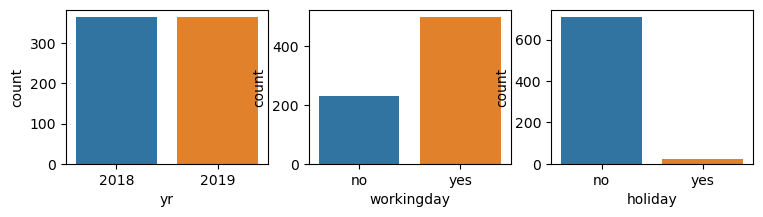

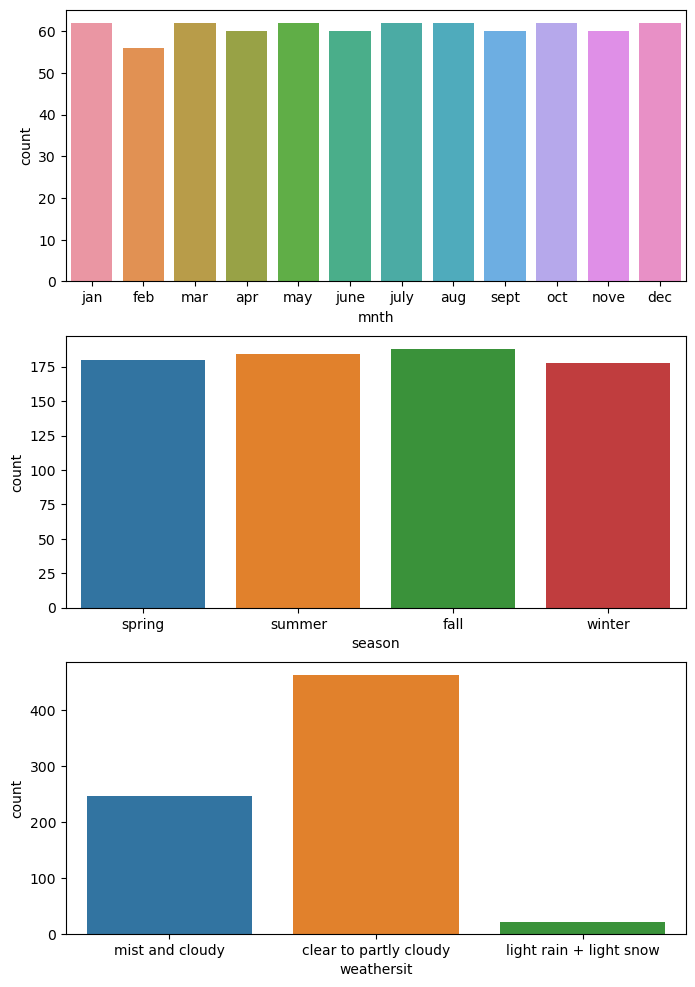

In [30]:
cat_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit']
plt.suptitle('Countplots of Category Features')
plt.figure(figsize=(12,2))
for index, feature in enumerate(["yr","workingday","holiday"]):
    plt.subplot(1,4,index+1)
    sns.countplot(boombikes_df[feature])
plt.show()
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
sns.countplot(boombikes_df.mnth)
plt.subplot(3,1,2)
sns.countplot(boombikes_df.season)
plt.subplot(3,1,3)
sns.countplot(boombikes_df.weathersit)
plt.show()


Observation:
    
    In year 2018 and 2019, the usage of bikes is same (i.e, 365 each)
    
    In workingday the usage is higher than in non-workingday.
    
    Non-holiday usage is verymuch higher than holiday usage.
    
    On everymonth the usage is almost similar.
    
    In all seasons, the usage is almost similar.
    
    Coming to weathersit, the usage in "clear to partly cloudy" condition is very much higher than other two situations.
    

#### Bivariate Analysis

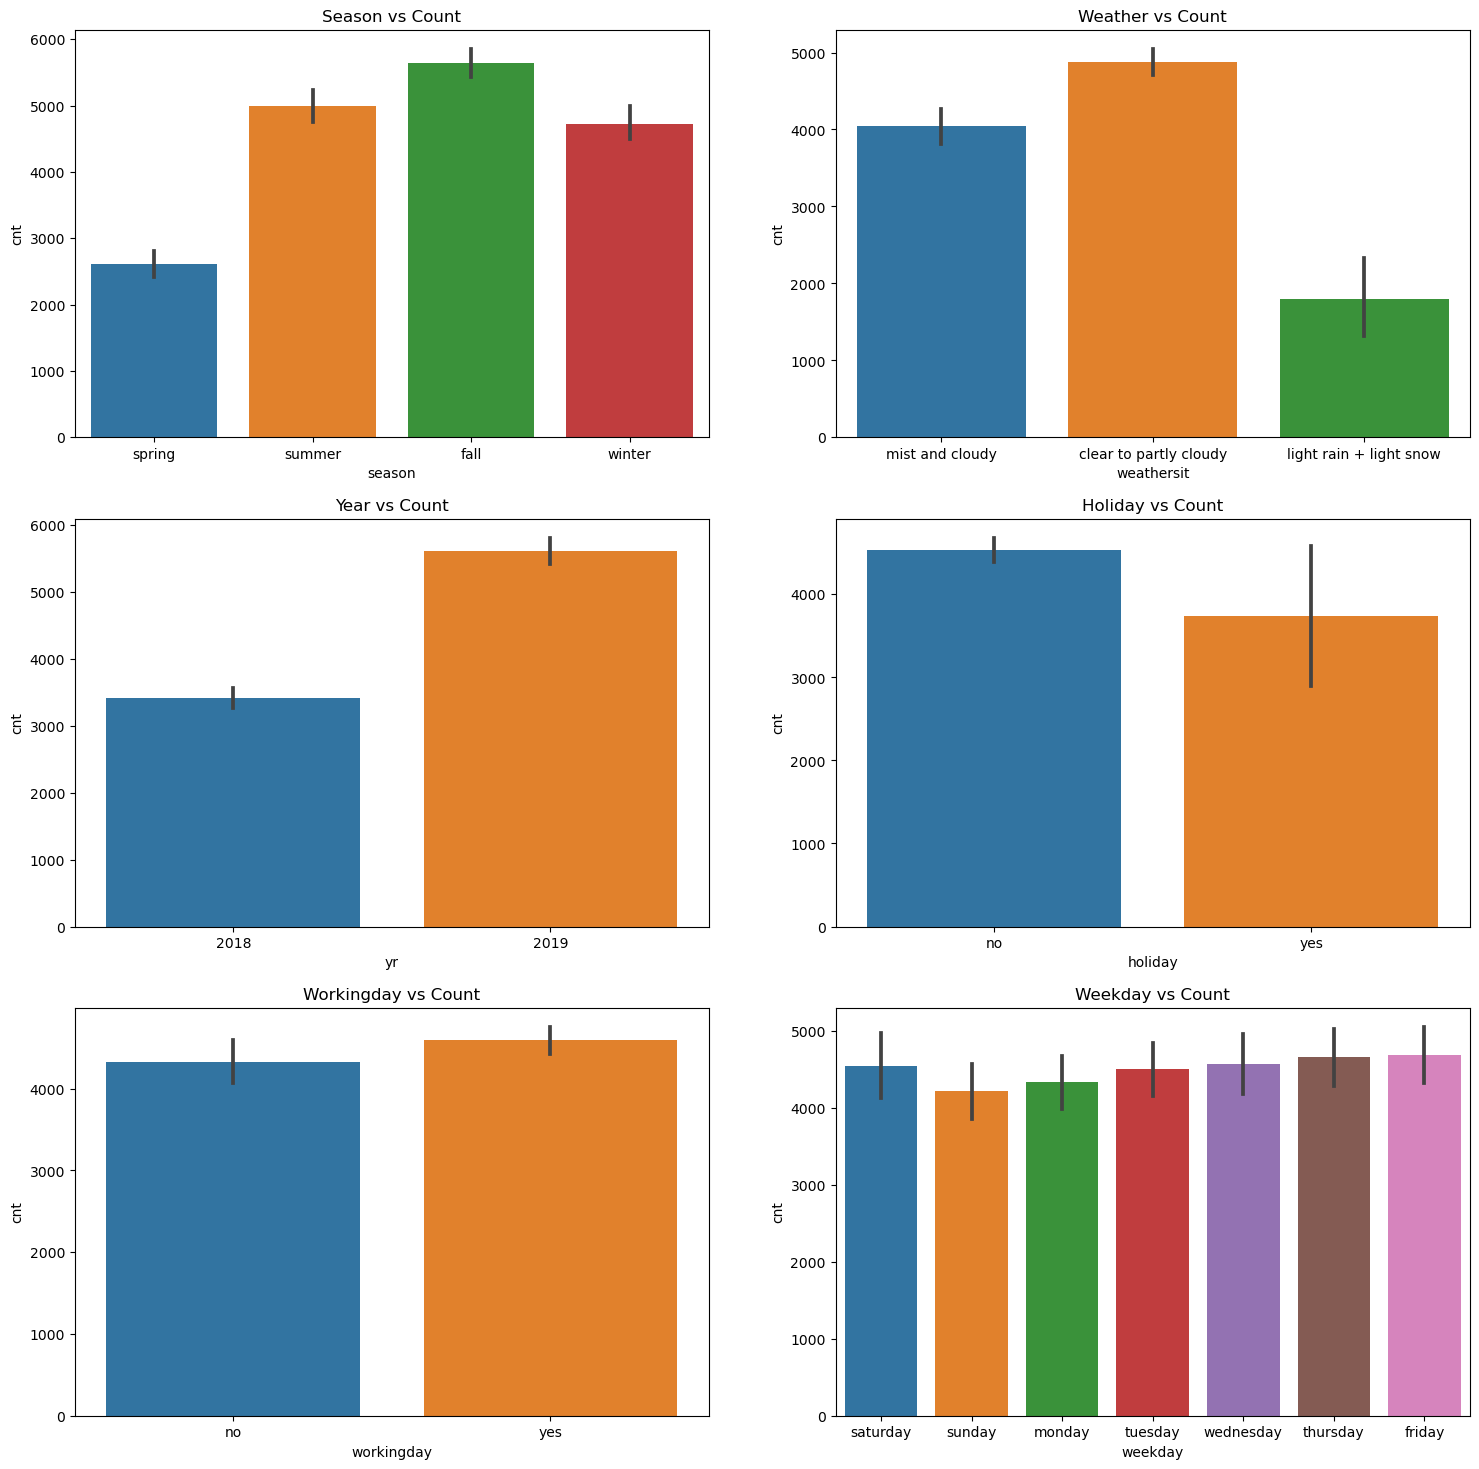

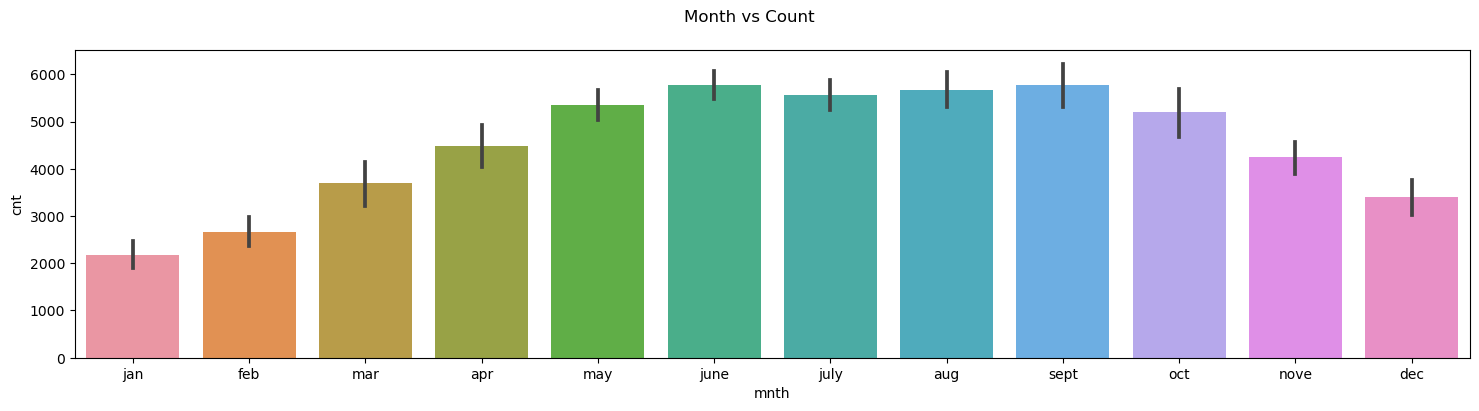

In [31]:
plt.figure(figsize=(18,18))
plt.subplot(3,2,1)
plt.title("Season vs Count")
sns.barplot(y="cnt", x="season", data=boombikes_df, orient='v')
plt.subplot(3,2,2)
plt.title("Weather vs Count")
sns.barplot(y="cnt", x="weathersit", data=boombikes_df, orient='v')
plt.subplot(3,2,3)
plt.title("Year vs Count")
sns.barplot(y="cnt", x="yr", data=boombikes_df, orient='v')
plt.subplot(3,2,4)
plt.title("Holiday vs Count")
sns.barplot(y="cnt", x="holiday", data=boombikes_df, orient='v')
plt.subplot(3,2,5)
plt.title("Workingday vs Count")
sns.barplot(y="cnt", x="workingday", data=boombikes_df, orient='v')
plt.subplot(3,2,6)
plt.title("Weekday vs Count")
sns.barplot(y="cnt", x="weekday", data=boombikes_df, orient='v')
plt.show()
plt.figure(figsize=(18,4))
plt.suptitle("Month vs Count")
sns.barplot(y="cnt", x="mnth",data=boombikes_df, orient='v')
plt.show()

In [32]:
cat_features

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

#### Multivariate Analysis

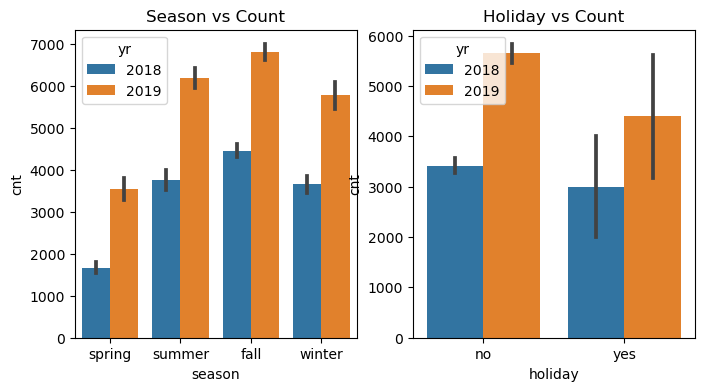

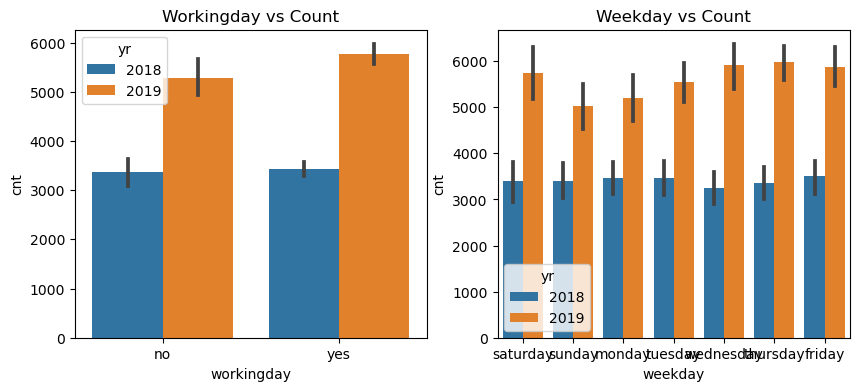

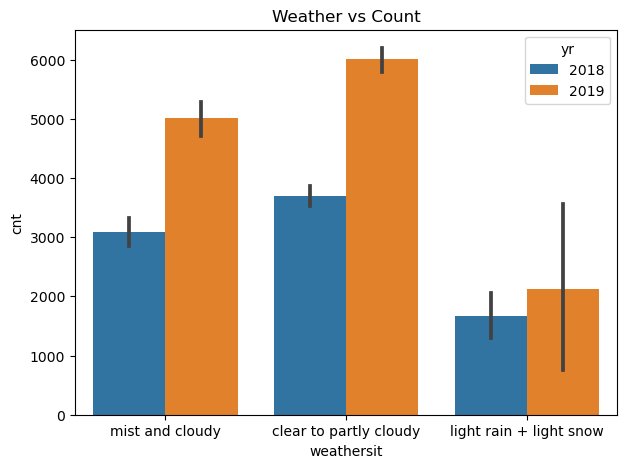

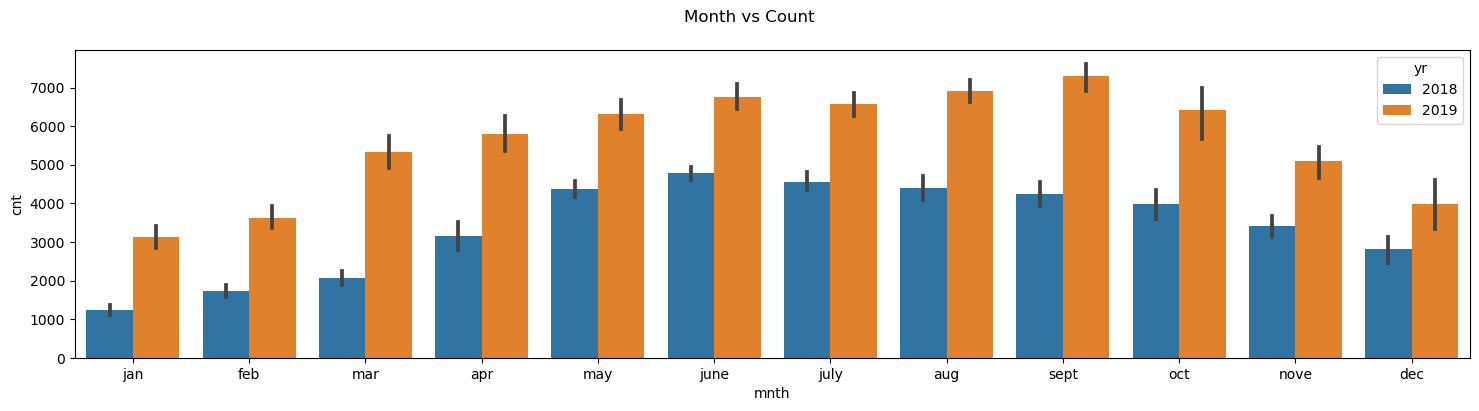

In [33]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Season vs Count")
sns.barplot(y="cnt", x="season", hue = "yr", data=boombikes_df, orient='v')
plt.subplot(1,2,2)
plt.title("Holiday vs Count")
sns.barplot(y="cnt", x="holiday", hue = "yr", data=boombikes_df, orient='v')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Workingday vs Count")
sns.barplot(y="cnt", x="workingday", hue = "yr", data=boombikes_df, orient='v')
plt.subplot(1,2,2)
plt.title("Weekday vs Count")
sns.barplot(y="cnt", x="weekday",hue = "yr",  data=boombikes_df, orient='v',)
plt.show()

plt.figure(figsize=(7,5))
plt.title("Weather vs Count")
sns.barplot(y="cnt", x="weathersit", hue = "yr",  data=boombikes_df, orient='v')
plt.show()

plt.figure(figsize=(18,4))
plt.suptitle("Month vs Count")
sns.barplot(y="cnt", x="mnth",hue = "yr",data=boombikes_df, orient='v')
plt.show()

Observation:

    In 2019, demand for bikes has increased than in 2018 for all the independent features
    Mostly the demand is in between Apr to Oct on each year.
    
    The demand in summer, fall, winter seasons is more than in spring season.
    

In [34]:
boombikes_df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

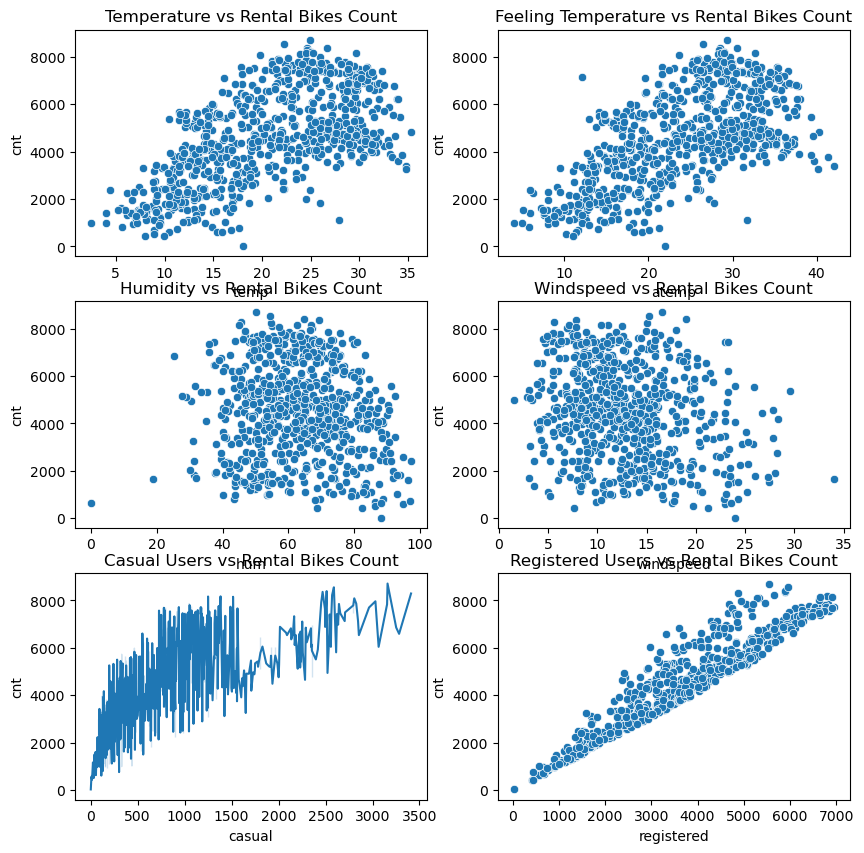

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.title("Temperature vs Rental Bikes Count")
sns.scatterplot(x='temp',y = "cnt", data=boombikes_df)
plt.subplot(3,2,2)
plt.title("Feeling Temperature vs Rental Bikes Count")
sns.scatterplot(x='atemp',y = "cnt", data=boombikes_df)
plt.subplot(3,2,3)
plt.title("Humidity vs Rental Bikes Count")
sns.scatterplot(x='hum',y = "cnt", data=boombikes_df)
plt.subplot(3,2,4)
plt.title("Windspeed vs Rental Bikes Count")
sns.scatterplot(x='windspeed',y = "cnt", data=boombikes_df)
plt.subplot(3,2,5)
plt.title("Casual Users vs Rental Bikes Count")
sns.lineplot(x='casual',y = "cnt", data=boombikes_df)
plt.subplot(3,2,6)
plt.title("Registered Users vs Rental Bikes Count")
sns.scatterplot(x='registered',y = "cnt", data=boombikes_df)
plt.show()

In [36]:
boombikes_df.corr()

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.542731,0.539436,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.543362,0.543678,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.075211,-0.089212,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.167995,-0.217914,-0.235132
casual,0.542731,0.543362,-0.075211,-0.167995,1.000000,0.394137,0.672123
registered,0.539436,0.543678,-0.089212,-0.217914,0.394137,1.000000,0.945411
cnt,0.627044,0.630685,-0.098543,-0.235132,0.672123,0.945411,1.000000


<AxesSubplot:>

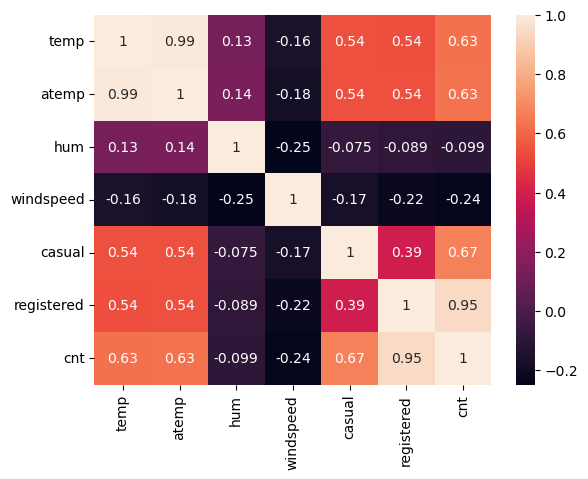

In [37]:
sns.heatmap(boombikes_df.corr(), annot=True)

Observations:
    
    Independent variables - "temp", "atemp" are highly positive correlated with each other.
    
    As per given data, 'cnt' is sum of 'casual' and 'registered'. 'registered' is highly correlated with 'cnt. (we can drop both 'casual' and 'registered' as they are being explained by 'cnt')
    

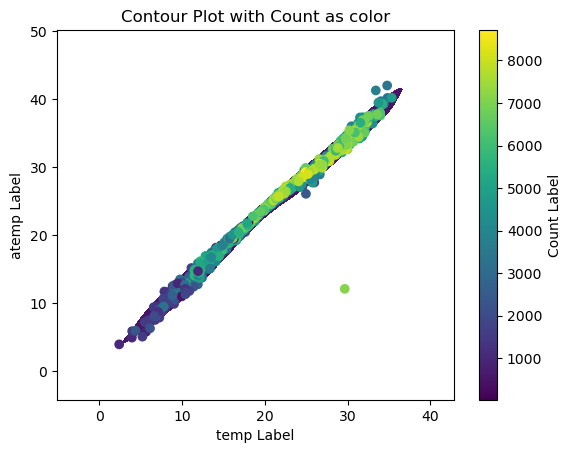

In [38]:
# Contour Plot
sns.kdeplot(data=boombikes_df, x='temp', y='atemp', fill=True, cmap='viridis')
plt.scatter(boombikes_df['temp'], boombikes_df['atemp'], c=boombikes_df['cnt'], cmap='viridis')
plt.colorbar(label='Count Label')
plt.xlabel('temp Label')
plt.ylabel('atemp Label')
plt.title('Contour Plot with Count as color')
plt.show()

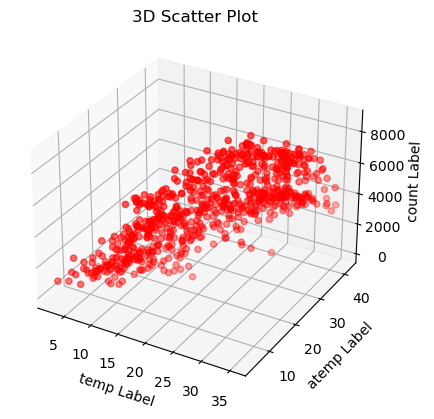

In [39]:
# 3D scarre plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(boombikes_df['temp'], boombikes_df['atemp'], boombikes_df['cnt'], 
           c='r', marker='o')
ax.set_xlabel('temp Label')
ax.set_ylabel('atemp Label')
ax.set_zlabel('count Label')
plt.title('3D Scatter Plot')
plt.show()

Observation from Contour Plot 3D scatterplot:
    
    As the 'temp' increases, 'atemp' increases and simultaneously 'cnt' also increases. 
    So that, both 'temp', 'atemp' are contributing resulting in increasing the demand of bikes.
    Positively Linear Relationship.
    
    One of the idependent features 'temp' and 'atemp' shall be removed by checking the VIF.

In [40]:
# dropping 'casual' and 'registered' features
boombikes_df.drop(labels=['casual', 'registered'], axis=1, inplace=True)

### Encoding the Categorical Variables

In [41]:
boombikes_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,no,saturday,no,mist and cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,no,sunday,no,mist and cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,no,monday,yes,clear to partly cloudy,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,no,tuesday,yes,clear to partly cloudy,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,no,wednesday,yes,clear to partly cloudy,9.305237,11.46350,43.6957,12.522300,1600


In [42]:
# checking the number of unique values in the features
boombikes_df.select_dtypes(include='object').nunique()

season         4
yr             2
mnth          12
holiday        2
weekday        7
workingday     2
weathersit     3
dtype: int64

Observation:
    
    'yr','holiday', 'workingday' has two unique values each. Hence, they can be converted into numerical features using Binary Encoding.
    
    'yr': {'2018':0,'2019':1}
    'holiday': {'yes':1, 'no':0}
    'workingday': {'yes':1, 'no':0}
    
    Other features - ['season','weekday','mnth','weathersit'] can be converted using get_dummies.

In [43]:
# Binary Encoding for ['yr', 'holiday','workingday']
boombikes_df.yr.replace({'2018':0,'2019': 1}, inplace=True)
boombikes_df.holiday.replace({'yes':1, 'no':0}, inplace=True)
boombikes_df.workingday.replace({'yes':1, 'no':0}, inplace=True)

# using get_dummies on ['season','weekday','mnth','weathersit']
boombikes_df = pd.get_dummies(boombikes_df, prefix= ['season','weekday','mnth','weathersit'], 
                              drop_first=True)

In [44]:
boombikes_df.sample(10)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,weekday_oct,weekday_sept,mnth_monday,mnth_saturday,mnth_sunday,mnth_thursday,mnth_tuesday,mnth_wednesday,weathersit_light rain + light snow,weathersit_mist and cloudy
188,0,0,1,29.075847,33.52415,75.7917,15.083643,4040,0,0,...,0,0,0,0,0,0,0,0,0,1
221,0,0,1,31.433347,34.24915,42.4167,13.417286,4780,0,0,...,0,0,0,0,0,0,0,1,0,0
248,0,0,1,22.140000,25.76000,88.6957,23.044181,2710,0,0,...,0,1,0,0,0,0,1,0,1,0
322,0,0,0,13.495847,16.22415,50.2083,15.041232,3663,0,0,...,0,0,0,1,0,0,0,0,0,0
99,0,0,0,17.493347,21.33685,85.7500,9.833389,2895,0,1,...,0,0,0,0,1,0,0,0,0,1
471,1,0,1,24.941653,29.92435,39.0417,18.333143,6691,0,1,...,0,0,0,0,0,0,1,0,0,0
25,0,0,1,8.917500,10.18000,86.2500,19.687950,506,1,0,...,0,0,0,0,0,0,0,1,1,0
190,0,0,0,30.647500,34.50125,57.8333,12.292557,4881,0,0,...,0,0,0,0,1,0,0,0,0,0
629,1,0,0,26.650000,30.52440,64.6667,19.000061,8395,0,0,...,0,1,0,1,0,0,0,0,0,0
491,1,0,1,22.037500,26.35710,66.4167,15.458307,6273,0,1,...,0,0,1,0,0,0,0,0,0,1


In [45]:
# dataset
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   yr                                  730 non-null    int64  
 1   holiday                             730 non-null    int64  
 2   workingday                          730 non-null    int64  
 3   temp                                730 non-null    float64
 4   atemp                               730 non-null    float64
 5   hum                                 730 non-null    float64
 6   windspeed                           730 non-null    float64
 7   cnt                                 730 non-null    int64  
 8   season_spring                       730 non-null    uint8  
 9   season_summer                       730 non-null    uint8  
 10  season_winter                       730 non-null    uint8  
 11  weekday_aug                         730 non-n

In [46]:
boombikes_df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_spring', 'season_summer', 'season_winter', 'weekday_aug',
       'weekday_dec', 'weekday_feb', 'weekday_jan', 'weekday_july',
       'weekday_june', 'weekday_mar', 'weekday_may', 'weekday_nove',
       'weekday_oct', 'weekday_sept', 'mnth_monday', 'mnth_saturday',
       'mnth_sunday', 'mnth_thursday', 'mnth_tuesday', 'mnth_wednesday',
       'weathersit_light rain + light snow', 'weathersit_mist and cloudy'],
      dtype='object')

## Train, Test Split

In [47]:
df_train, df_test = train_test_split(boombikes_df, train_size=0.70, 
                                     test_size=0.30, random_state=100)

print(f'Training set:{df_train.shape}')
print(f'Test set:{df_test.shape}')



Training set:(510, 30)
Test set:(219, 30)


### Scaling

In [48]:
num_features

['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

In [49]:
num_vars =  ['temp', 'atemp', 'hum', 'windspeed','cnt']


scalar = MinMaxScaler()
df_train[num_vars] = scalar.fit_transform(df_train[num_vars])


In [50]:
df_train.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,weekday_oct,weekday_sept,mnth_monday,mnth_saturday,mnth_sunday,mnth_thursday,mnth_tuesday,mnth_wednesday,weathersit_light rain + light snow,weathersit_mist and cloudy
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,1,0,0,0,0,0,1


In [51]:
df_train.describe()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,weekday_oct,weekday_sept,mnth_monday,mnth_saturday,mnth_sunday,mnth_thursday,mnth_tuesday,mnth_wednesday,weathersit_light rain + light snow,weathersit_mist and cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,...,0.086275,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,...,0.281045,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# seperating independent and dependent variables
y_train = df_train.pop('cnt')
X_train = df_train

In [53]:
print(f'X_train shape : {X_train.shape}, y_train shape:{y_train.shape}')


X_train shape : (510, 29), y_train shape:(510,)


## Model Building

In [54]:
# Model-1
# with all features
# Building a model with all features using statsmodels :
X_train_lm = sm.add_constant(X_train)
lm1= sm.OLS(y_train, X_train_lm).fit()
lm1.params

const                                 0.245237
yr                                    0.232208
holiday                               0.010689
workingday                            0.096962
temp                                  0.401322
atemp                                 0.050628
hum                                  -0.151812
windspeed                            -0.184388
season_spring                        -0.048580
season_summer                         0.038216
season_winter                         0.105387
weekday_aug                           0.016076
weekday_dec                          -0.045572
weekday_feb                          -0.032176
weekday_jan                          -0.062565
weekday_july                         -0.039277
weekday_june                         -0.001704
weekday_mar                           0.001288
weekday_may                           0.024691
weekday_nove                         -0.041783
weekday_oct                           0.007695
weekday_sept 

In [55]:
lm1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          8.42e-181
Time:                        22:41:45   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.2452      0.035      6.953      0.000       0.176       0.315
yr                                     0.2322      0.008     28.792      0.000       0.216       0.248
holiday                                0.0107      0.024      0.443      0.658      -0.037       0.058
workingday                             0.0970      0.012      7.903      0.000       0.073       0.121
temp                                   0.4013      0.142      2.821      0.005       0.122       0.681
atemp                                  0.0506      0.138      0.366      0.714      -0.221       0.322
hum                                   -0.1518      0.039     -3.940      0.000      -0.228      -0.076
windspeed                             -0.1844      0.026     -7.003      0.000      -0.236      -0.133
season_spring                         -0.0486      0.030     -1.618      0.106      -0.108       0.010
season_summer                          0.0382      0.026      1.455      0.146      -0.013       0.090
season_winter                          0.1054      0.028      3.770      0.000       0.050       0.160
weekday_aug                            0.0161      0.034      0.473      0.637      -0.051       0.083
weekday_dec                           -0.0456      0.034     -1.356      0.176      -0.112       0.020
weekday_feb                           -0.0322      0.033     -0.978      0.329      -0.097       0.032
weekday_jan                           -0.0626      0.034     -1.864      0.063      -0.129       0.003
weekday_july                          -0.0393      0.035     -1.116      0.265      -0.108       0.030
weekday_june                          -0.0017      0.025     -0.067      0.946      -0.051       0.048
weekday_mar                            0.0013      0.025      0.052      0.958      -0.047       0.050
weekday_may                            0.0247      0.021      1.169      0.243      -0.017       0.066
weekday_nove                          -0.0418      0.036     -1.149      0.251      -0.113       0.030
weekday_oct                            0.0077      0.036      0.215      0.830      -0.063       0.078
weekday_sept                           0.0818      0.032      2.549      0.011       0.019       0.145
mnth_monday                           -0.0215      0.015     -1.395      0.164      -0.052       0.009
mnth_saturday                          0.0961      0.014      6.984      0.000       0.069       0.123
mnth_sunday                            0.0415      0.014      2.974      0.003       0.014       0.069
mnth_thursday                         -0.0097      0.016     -0.625      0.532      -0.040       0.021
mnth_tuesday                          -0.0193      0.016     -1.242      0.215      -0.050      

Observation:
    
    R-squared value is 0.853 is pretty good. Let us find if any dimentionality reduction can improve this score.
    
    By using RFE (Recursive Feature Elimination), will select the top 15 features for the model instead of 30 features.

In [56]:
# Fit a linear regression model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

# Apply Recursive Feature Elimination (RFE) to select the top 15 features
rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [57]:
# observation of result
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('weekday_aug', False, 13),
 ('weekday_dec', False, 3),
 ('weekday_feb', False, 4),
 ('weekday_jan', True, 1),
 ('weekday_july', True, 1),
 ('weekday_june', False, 5),
 ('weekday_mar', False, 9),
 ('weekday_may', False, 15),
 ('weekday_nove', False, 2),
 ('weekday_oct', False, 11),
 ('weekday_sept', True, 1),
 ('mnth_monday', False, 14),
 ('mnth_saturday', True, 1),
 ('mnth_sunday', False, 7),
 ('mnth_thursday', False, 12),
 ('mnth_tuesday', False, 8),
 ('mnth_wednesday', False, 10),
 ('weathersit_light rain + light snow', True, 1),
 ('weathersit_mist and cloudy', True, 1)]

In [58]:
# RFE support Variables
col = X_train.columns[rfe.support_]
print(len(col))
print(col)

15
Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'weekday_jan',
       'weekday_july', 'weekday_sept', 'mnth_saturday',
       'weathersit_light rain + light snow', 'weathersit_mist and cloudy'],
      dtype='object')


In [59]:
# RFE not Supported Variables
X_train.columns[~rfe.support_]

Index(['atemp', 'weekday_aug', 'weekday_dec', 'weekday_feb', 'weekday_june',
       'weekday_mar', 'weekday_may', 'weekday_nove', 'weekday_oct',
       'mnth_monday', 'mnth_sunday', 'mnth_thursday', 'mnth_tuesday',
       'mnth_wednesday'],
      dtype='object')

In [60]:
# Lets consider only  the RFE supported columns for first model building 
X_train_1 = X_train[col]

In [61]:
# Model-2
X_train_lm2 = sm.add_constant(X_train_1)

# Create a first fitted model
lm2 = sm.OLS(y_train, X_train_lm2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          2.31e-191
Time:                        22:41:45   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.2510      0.036      6.949      0.000       0.180       0.322
yr                                     0.2305      0.008     28.807      0.000       0.215       0.246
holiday                               -0.0585      0.027     -2.178      0.030      -0.111      -0.006
workingday                             0.0435      0.012      3.781      0.000       0.021       0.066
temp                                   0.5098      0.034     14.851      0.000       0.442       0.577
hum                                   -0.1547      0.037     -4.145      0.000      -0.228      -0.081
windspeed                             -0.1860      0.025     -7.301      0.000      -0.236      -0.136
season_spring                         -0.0508      0.021     -2.461      0.014      -0.091      -0.010
season_summer                          0.0497      0.015      3.346      0.001       0.020       0.079
season_winter                          0.0944      0.017      5.479      0.000       0.061       0.128
weekday_jan                           -0.0343      0.017     -1.980      0.048      -0.068      -0.000
weekday_july                          -0.0532      0.018     -2.947      0.003      -0.089      -0.018
weekday_sept                           0.0812      0.016      4.934      0.000       0.049       0.114
mnth_saturday                          0.0537      0.014      3.707      0.000       0.025       0.082
weathersit_light rain + light snow    -0.2488      0.026     -9.560      0.000      -0.300      -0.198
weathersit_mist and cloudy            -0.0578      0.010     -5.574      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       66.344   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.565
Skew:                          -0.676   Prob(JB):                     8.25e-36
Kurtosis:                       5.403   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# VIF Calculation

vif = pd.DataFrame()
vif['Features'] = X_train_1.columns
vif['VIF'] = [variance_inflation_factor(X_train_1.values, i) for i in range(X_train_1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
4,hum,29.40
3,temp,17.77
2,workingday,5.31
5,windspeed,4.73
6,season_spring,4.53
8,season_winter,3.48
7,season_summer,2.84
14,weathersit_mist and cloudy,2.29
0,yr,2.09
12,mnth_saturday,1.98


Observation: 
    
    VIF of 'hum' is very high. This feature can be eliminated and proceed further.
    

In [63]:
X_train_2 = X_train_1.drop(["hum"], axis = 1)
X_train_2.head()

,yr,holiday,workingday,temp,windspeed,season_spring,season_summer,season_winter,weekday_jan,weekday_july,weekday_sept,mnth_saturday,weathersit_light rain + light snow,weathersit_mist and cloudy
653,1,0,1,0.509887,0.300794,0,0,1,0,0,0,0,0,0
576,1,0,1,0.815169,0.264686,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.255342,1,0,0,0,0,0,1,0,1
728,1,0,0,0.245101,0.663106,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.188475,0,1,0,0,0,0,1,0,1


In [64]:
# Model-3 after removing "hum"

X_train_lm3 = sm.add_constant(X_train_2)

# Create a first fitted model
lm3 = sm.OLS(y_train, X_train_lm3).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.3
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          7.33e-189
Time:                        22:41:46   Log-Likelihood:                 511.16
No. Observations:                 510   AIC:                            -992.3
Df Residuals:                     495   BIC:                            -928.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.1737      0.031      5.525      0.000       0.112       0.235
yr                                     0.2344      0.008     29.019      0.000       0.218       0.250
holiday                               -0.0562      0.027     -2.058      0.040      -0.110      -0.003
workingday                             0.0465      0.012      3.983      0.000       0.024       0.069
temp                                   0.4728      0.034     14.037      0.000       0.407       0.539
windspeed                             -0.1563      0.025     -6.292      0.000      -0.205      -0.107
season_spring                         -0.0597      0.021     -2.861      0.004      -0.101      -0.019
season_summer                          0.0434      0.015      2.890      0.004       0.014       0.073
season_winter                          0.0797      0.017      4.650      0.000       0.046       0.113
weekday_jan                           -0.0389      0.018     -2.215      0.027      -0.073      -0.004
weekday_july                          -0.0482      0.018     -2.635      0.009      -0.084      -0.012
weekday_sept                           0.0753      0.017      4.522      0.000       0.043       0.108
mnth_saturday                          0.0584      0.015      3.980      0.000       0.030       0.087
weathersit_light rain + light snow    -0.2917      0.024    -12.027      0.000      -0.339      -0.244
weathersit_mist and cloudy            -0.0826      0.009     -9.592      0.000      -0.100      -0.066
==============================================================================
Omnibus:                       67.959   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.078
Skew:                          -0.690   Prob(JB):                     8.64e-37
Kurtosis:                       5.431   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# VIF Calculation

vif = pd.DataFrame()
vif['Features'] = X_train_2.columns
vif['VIF'] = [variance_inflation_factor(X_train_2.values, i) for i in range(X_train_2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,temp,7.07
2,workingday,5.24
4,windspeed,4.67
5,season_spring,3.08
6,season_summer,2.33
0,yr,2.08
7,season_winter,1.99
11,mnth_saturday,1.97
8,weekday_jan,1.62
9,weekday_july,1.59


Observation:
    
    VIF of "temp" is > 5. Will eliminate this feature and check further.

In [66]:
X_train_3 = X_train_2.drop(["temp"], axis = 1)
X_train_3.head()

,yr,holiday,workingday,windspeed,season_spring,season_summer,season_winter,weekday_jan,weekday_july,weekday_sept,mnth_saturday,weathersit_light rain + light snow,weathersit_mist and cloudy
653,1,0,1,0.300794,0,0,1,0,0,0,0,0,0
576,1,0,1,0.264686,0,0,0,0,1,0,0,0,0
426,1,0,0,0.255342,1,0,0,0,0,0,1,0,1
728,1,0,0,0.663106,1,0,0,0,0,0,0,0,0
482,1,0,0,0.188475,0,1,0,0,0,0,1,0,1


In [67]:
# Model-4

X_train_lm4 = sm.add_constant(X_train_3)

# Create a first fitted model
lm4 = sm.OLS(y_train, X_train_lm4).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     136.0
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          4.04e-154
Time:                        22:41:46   Log-Likelihood:                 425.72
No. Observations:                 510   AIC:                            -823.4
Df Residuals:                     496   BIC:                            -764.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.5448      0.020     27.136      0.000       0.505       0.584
yr                                     0.2478      0.009     26.156      0.000       0.229       0.266
holiday                               -0.0571      0.032     -1.771      0.077      -0.120       0.006
workingday                             0.0480      0.014      3.482      0.001       0.021       0.075
windspeed                             -0.1878      0.029     -6.429      0.000      -0.245      -0.130
season_spring                         -0.2603      0.018    -14.490      0.000      -0.296      -0.225
season_summer                         -0.0440      0.016     -2.729      0.007      -0.076      -0.012
season_winter                         -0.0749      0.016     -4.829      0.000      -0.105      -0.044
weekday_jan                           -0.1024      0.020     -5.104      0.000      -0.142      -0.063
weekday_july                          -0.0099      0.021     -0.461      0.645      -0.052       0.032
weekday_sept                           0.0708      0.020      3.601      0.000       0.032       0.109
mnth_saturday                          0.0564      0.017      3.252      0.001       0.022       0.090
weathersit_light rain + light snow    -0.3045      0.029    -10.634      0.000      -0.361      -0.248
weathersit_mist and cloudy            -0.0896      0.010     -8.824      0.000      -0.110      -0.070
==============================================================================
Omnibus:                       34.622   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.832
Skew:                          -0.419   Prob(JB):                     3.07e-15
Kurtosis:                       4.563   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# VIF Calculation

vif = pd.DataFrame()
vif['Features'] = X_train_3.columns
vif['VIF'] = [variance_inflation_factor(X_train_3.values, i) for i in range(X_train_3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,windspeed,4.27
2,workingday,3.83
4,season_spring,2.97
5,season_summer,2.27
6,season_winter,1.99
0,yr,1.91
10,mnth_saturday,1.69
7,weekday_jan,1.60
12,weathersit_mist and cloudy,1.56
8,weekday_july,1.30


Observation:
    
    There is huge drop of R2-Score after removing the feature "temp".
    We have seen that, "atemp", and "temp" are in positive linear relationship with target variable "cnt"
    "atemp" is already eliminated by RFE. Hence, this "temp" feature is impacting more on target variable as well as the model performance.
    Hence, we keep this variable for building the final model.
    
   The final model is **Model-3**

### Linear Regression Assumptions

#### Normality of Residuals

In [69]:
y_train_pred = lm3.predict(X_train_lm3)  
residual = y_train - y_train_pred

<Figure size 800x400 with 0 Axes>

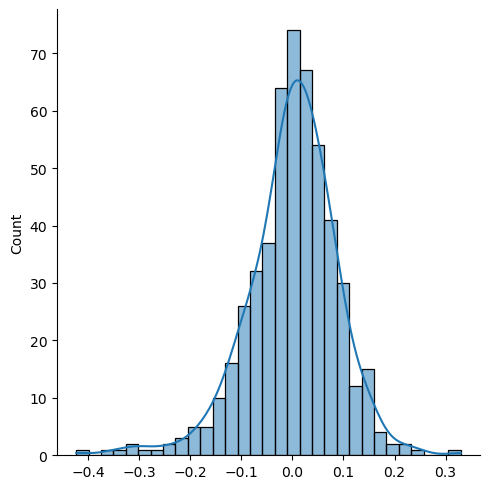

In [70]:
plt.figure(figsize = (8,4))
plt.suptitle("Residual Analysis")
sns.displot(residual, kde=True)
plt.show()

Observation:
    
    Residuals (Error) is normally distributed around the mean.

#### Homoscedasticity

Text(0, 0.5, 'Residuals')

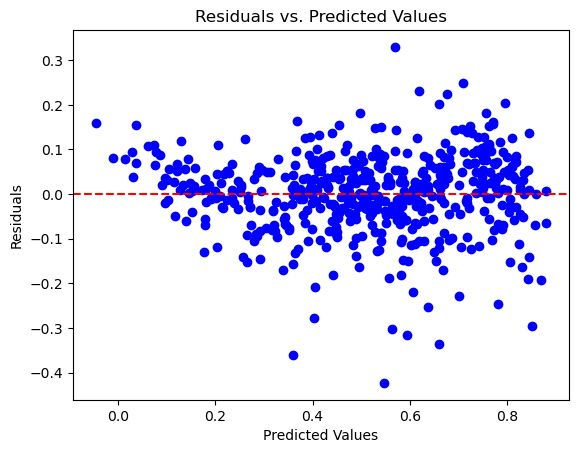

In [72]:
# Plot residuals against predicted values
plt.scatter(y_train_pred, residual, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Observation:

    The scatterplot between Residuals, Predicted values is Random Cloud and is Homoscadastic in Nature

### Model Testing

In [73]:
# Scaling on test dataset
df_test.describe()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,weekday_oct,weekday_sept,mnth_monday,mnth_saturday,mnth_sunday,mnth_thursday,mnth_tuesday,mnth_wednesday,weathersit_light rain + light snow,weathersit_mist and cloudy
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,20.815737,24.255828,61.961883,12.600130,4546.981735,0.255708,0.264840,...,0.082192,0.086758,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.027397,0.319635
std,0.500722,0.188034,0.459904,7.689600,8.299641,14.456669,4.984858,1898.633630,0.437258,0.442259,...,0.275286,0.282125,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.163612,0.467403
min,0.000000,0.000000,0.000000,3.957390,4.941955,25.416700,1.500244,441.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.093750,17.085500,51.166700,9.021282,3303.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,20.807500,24.873150,60.916700,12.167200,4579.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,27.401653,31.155725,72.192050,15.395629,5869.500000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,34.815847,41.318550,97.250000,27.999836,8395.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:

#creating list of numeric columns which are not yet scalled
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

df_test[num_vars] = scalar.transform(df_test[num_vars])

In [75]:
df_test.describe()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,weekday_oct,weekday_sept,mnth_monday,mnth_saturday,mnth_sunday,mnth_thursday,mnth_tuesday,mnth_wednesday,weathersit_light rain + light snow,weathersit_mist and cloudy
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.255708,0.264840,...,0.082192,0.086758,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.027397,0.319635
std,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.437258,0.442259,...,0.275286,0.282125,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.163612,0.467403
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
y_test = df_test.pop('cnt')
X_test = df_test
X_test.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,weekday_oct,weekday_sept,mnth_monday,mnth_saturday,mnth_sunday,mnth_thursday,mnth_tuesday,mnth_wednesday,weathersit_light rain + light snow,weathersit_mist and cloudy
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,0,...,0,0,1,0,0,0,0,0,0,1
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,0,...,0,0,0,0,0,0,0,1,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,1,0,0,0,0,1,0,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [77]:
print(f'X_test shape : {X_test.shape}, y_test shape:{y_test.shape}')


X_test shape : (219, 29), y_test shape:(219,)


In [78]:
# Final Trained model is Model -4 where trained data is X_train_3 and model is lm4
X_test=X_test[X_train_3.columns]  
# Adding constant variable to test dataframe
X_test_lm4 = sm.add_constant(X_test)
X_test_lm4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 184 to 72
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   const                               219 non-null    float64
 1   yr                                  219 non-null    int64  
 2   holiday                             219 non-null    int64  
 3   workingday                          219 non-null    int64  
 4   windspeed                           219 non-null    float64
 5   season_spring                       219 non-null    uint8  
 6   season_summer                       219 non-null    uint8  
 7   season_winter                       219 non-null    uint8  
 8   weekday_jan                         219 non-null    uint8  
 9   weekday_july                        219 non-null    uint8  
 10  weekday_sept                        219 non-null    uint8  
 11  mnth_saturday                       219 non-

In [79]:
# Predict on the test data
y_test_pred = lm4.predict(X_test_lm4)

Text(0, 0.5, 'y_test_pred')

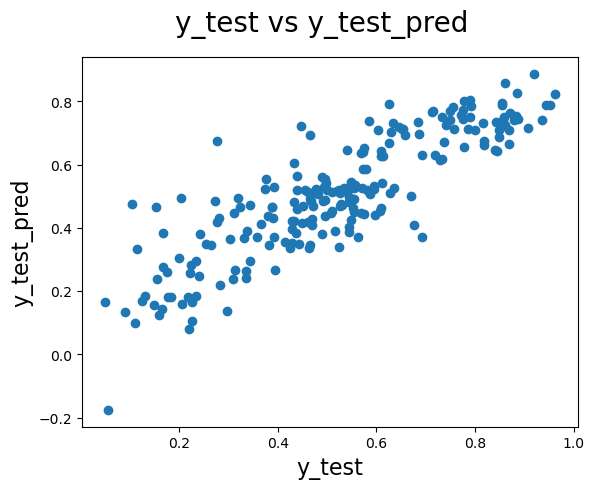

In [80]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=16)                              # X-label
plt.ylabel('y_test_pred', fontsize=16)            

In [83]:
# R-squared on the training data
r2_train = r2_score(y_train, y_train_pred)
print("Training Data R-squared:",r2_train)

# Adjusted R-squared on the training data
adj_r2_train = round(lm4.rsquared_adj,3)
print(f"Training Adjusted R-squared: {adj_r2_train}")

# Calculate R-squared on the test data
r2_test = round(r2_score(y_test, y_test_pred),3)
print(f"Test R-squared: {r2_test}")

# Calculate Adjusted R-squared on the test data
n_test = X_test.shape[0]
k = X_test.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - k - 1))

print("Test Adjusted R-squared:", adj_r2_test)

Training Data R-squared: 0.8433190474592366
Training Adjusted R-squared: 0.775
Test R-squared: 0.739
Test Adjusted R-squared: 0.7224487804878048


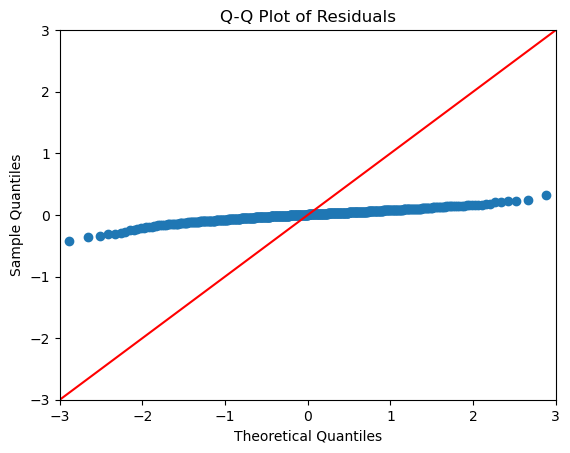

In [84]:
sm.qqplot(residual, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()